# Model hiper optimization

In [2]:
#imports
import os
from copy import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

In [3]:
# configs.
model_id = "1.1.b.2.f.6m"
%matplotlib inline

pd.set_option("display.max_columns", 500)

path = "../../data/split"
random_state = 42
print(os.listdir(path))

['1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.1 - df_train with nan.feather', '1.2.b - group zone - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1 - df_train.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to04-19.feather', '1.1 - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train without nulls.feather', '1.1 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train without nulls.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train only 2018 without nulls.fea

## Loading training and validation datasets

In [7]:
df = pd.read_feather(os.path.join(path, "1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather"))
df_val = pd.read_feather(os.path.join(path, "1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather"))

In [8]:
df_val["FECHA_SINI"].min(), df_val["FECHA_SINI"].max()

(Timestamp('2019-02-01 00:00:00'), Timestamp('2019-03-31 00:00:00'))

In [9]:
# dropping index variables
# to_drop = ["index"]
# df.drop(to_drop, axis=1, inplace=True)
# to_drop = ["level_0", "index"]
# df_val.drop(to_drop, axis=1, inplace=True)

In [10]:
# dropping NUM_SECU_EXPED
# to_drop = ["NUM_SECU_EXPED"]
# df.drop(to_drop, axis=1, inplace=True)
# df_val.drop(to_drop, axis=1, inplace=True)

In [11]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [12]:
# using only last year
df_train = df[df["FECHA_SINI"].between("2018-07-01", "2018-11-30") ].copy()
df_opt = df[df["FECHA_SINI"] >= "2018-12-01"].copy()
print(df_train["FECHA_SINI"].min(), df_train["FECHA_SINI"].max())
print(df_opt["FECHA_SINI"].min(), df_opt["FECHA_SINI"].max())

2018-07-01 00:00:00 2018-11-30 00:00:00
2018-12-01 00:00:00 2019-01-31 00:00:00


In [13]:
full_len = df_train.shape[0] + df_opt.shape[0]
df_train.shape[0] / full_len, df_opt.shape[0] / full_len

(0.7221719721063228, 0.2778280278936772)

In [14]:
# dropping date FEC_ACT_cond
to_drop = ["FECHA_SINI"]
df_train.drop(to_drop, axis=1, inplace=True)
df_opt.drop(to_drop, axis=1, inplace=True)
df_val.drop(to_drop, axis=1, inplace=True)

## split X, y dataset

In [15]:
# to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "EXISTE_INHABILITAR"]
# already removed : "EXISTE_INHABILITAR", "COD_ACT_BENEF",
to_drop = ["EXISTE_FRAUDE", "NUM_SECU_EXPED", "NUM_SECU_POL", "EXISTE_INVEST"]

# training
X_train = df_train.drop(to_drop, axis=1)
y_train = df_train["EXISTE_FRAUDE"]
# validation
X_opt = df_opt.drop(to_drop, axis=1)
y_opt = df_opt["EXISTE_FRAUDE"]
# validation
X_val = df_val.drop(to_drop, axis=1)
y_val = df_val["EXISTE_FRAUDE"]

In [16]:
X_full_train = df.drop(to_drop, axis=1)
X_full_train.drop(columns=["FECHA_SINI"], inplace=True)
y_full_train = df["EXISTE_FRAUDE"]

In [17]:
# checking if all have the same inputs columns
print("dif between X_train & X_opt: {}".format(set(X_train.columns) - set(X_opt.columns)))
print("dif between X_val & X_opt: {}".format(set(X_val.columns) - set(X_opt.columns)))

dif between X_train & X_opt: set()
dif between X_val & X_opt: set()


In [18]:
print(f"{len(X_train)}, {len(X_opt)}")
print(f"{len(y_train)}, {len(y_opt)}")

198008, 76176
198008, 76176


In [19]:
y_train.sum() / len(y_train), y_opt.sum() / len(y_opt)

(0.003883681467415458, 0.005592312539382483)

## short optimization

In [16]:
'''from sklearn.ensemble import forest
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))
'''
#set_rf_samples(60000)

'from sklearn.ensemble import forest\ndef set_rf_samples(n):\n    """ Changes Scikit learn\'s random forests to give each tree a random sample of\n    n random rows.\n    """\n    forest._generate_sample_indices = (lambda rs, n_samples:\n        forest.check_random_state(rs).randint(0, n_samples, n))\n\ndef reset_rf_samples():\n    """ Undoes the changes produced by set_rf_samples.\n    """\n    forest._generate_sample_indices = (lambda rs, n_samples:\n        forest.check_random_state(rs).randint(0, n_samples, n_samples))\n'

## Defining grid configuration

In [17]:
from sklearn.utils.class_weight import compute_class_weight

In [18]:
weights = compute_class_weight("balanced", df["EXISTE_FRAUDE"].unique(), df["EXISTE_FRAUDE"])
weights

array([  0.50192621, 130.28884965])

In [19]:
rf_params = {
    "n_estimators": [40, 200, 400],  # 100, 400
    "min_samples_leaf": [4, 55], # , 65
     "max_depth": [5,  15], # 10,
    "max_features": ['sqrt', 0.5, None],
    "class_weight": [{0:1, 1:9}, {0:1, 1:15},  {0:1, 1:18}] 
}

In [27]:
# using without grid with list of models
rfs = []
rfs.append(RandomForestClassifier(max_features="sqrt", random_state=random_state, n_jobs=-1))
rfs.append(ExtraTreesClassifier(random_state=random_state, n_jobs=-1))
# rf.fit(X_full_train, y_full_train)

In [28]:
# TO avoid random sampling,
# WE USE GridSearch of hypopt
metric = "f1"
best_models_ = []
best_scores_ = []
for counter, rf in enumerate(rfs):
    print(f"Model {counter}: {rf}")
    clf = GridSearch(rf, param_grid=rf_params, seed=random_state, num_threads=4)
    clf.fit(X_train, y_train, X_val=X_opt, y_val=y_opt, scoring=metric, verbose=True)
    print(f"Best score: {clf.best_score}")
    print(f"Best config: {clf.best_params}")
    best_models_.append(copy(clf.best_estimator_))
    best_scores_.append(clf.best_score)
    print("*-*-*-" * 10)

Model 0: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Comparing 108 parameter setting(s) using 4 CPU thread(s) ( 27 job(s) per thread ).


Process ForkPoolWorker-4:
Traceback (most recent call last):
  File "/home/voolkia/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/voolkia/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/voolkia/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/voolkia/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:


KeyboardInterrupt: 

  File "/home/voolkia/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Process ForkPoolWorker-3:
Traceback (most recent call last):
  File "/home/voolkia/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/voolkia/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/voolkia/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/voolkia/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/voolkia/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/voolkia/anaconda3/lib/python3.6/multiprocessing/connection.py", line 411, in _recv_bytes
    return self._recv(size)
  File "/home/voolkia/ana

In [ ]:
print("Best Config:")
print(clf.best_params, clf.best_score)

In [ ]:
print("Grid scores:")
sorted_ids = np.argsort(clf.scores)
for i in sorted_ids:
    print("%0.3f for %r" % (clf.scores[i], clf.params[i]))

In [31]:
clf.best_estimator_

In [29]:
# use without grid
df_train_opt = df[df["FECHA_SINI"].between("2018-07-01", "2019-01-31")]
clf.best_estimator_ = ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 18},
           criterion='gini', max_depth=15, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
X_train_opt = df_train_opt.drop(columns=["FECHA_SINI", "EXISTE_FRAUDE", "NUM_SECU_EXPED", "NUM_SECU_POL", "EXISTE_INVEST"])
y_train_opt = df_train_opt["EXISTE_FRAUDE"]
clf.best_estimator_.fit(X_train_opt, y_train_opt)

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 18},
           criterion='gini', max_depth=15, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [30]:
y_val_pred = clf.best_estimator_.predict(X_val)
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.43278688524590164, 0.8165088042775557)

In [31]:
confusion_matrix(y_val, y_val_pred)

array([[71096,   407],
       [  112,   198]])

In [ ]:
y_val_pred = clf.best_estimator_.predict(X_val)
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

In [ ]:
confusion_matrix(y_val, y_val_pred)

## dumping best current config

In [ ]:
# Current best config
"""
RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 15},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=55,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=60, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)
"""
# full features
# scores: 0.449, 0.971
# array([[71143,   360],
#       [  116,   194]])
# Tronador
# (0.3472,0.816)
# array([[70866,   637],
#        [  111,   199]])

In [ ]:
# with open(ps.path.join("models", "s1 - cond_preg_fill-1_ class_weight balanced.pickle"), "wb") as file:
#     pickle.dump(rf_f, file)

## Feature Importance

<h3 style="color:red">When reducing the # of features the model get worst</h3>

In [32]:
rf_fi = pd.DataFrame({'cols':X_train.columns, 'fi':clf.best_estimator_.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
30,es_gte_5,0.143178
88,TIPO_EXPED,0.092386
9,cond_C10,0.088330
10,cond_C11,0.063318
54,preg_33,0.057050
53,preg_32,0.055559
52,preg_31,0.054744
11,cond_C12,0.051996
6,cond_32,0.051603
29,total_condicion,0.049271


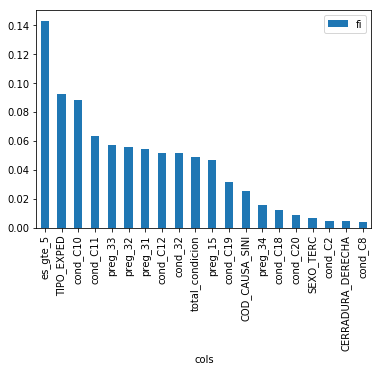

In [33]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [34]:
to_keep = list(rf_fi[rf_fi["fi"] >=0.005]["cols"].values)
print(f"# of features: {len(to_keep)} of {len(rf_fi)}")

# of features: 17 of 143


In [35]:
to_remove = ['COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019',
             'COD_POST_OCURRENCIA_RC_CLUSTER_2019',  'COD_POST_POLIZA_RC_CLUSTER_2019',
             'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019',
             "COD_CAUSA_SINI", 
            ] # "es_gte_5", "total_condicion", 
for col in to_remove:
    if(col in to_keep):
        to_keep.remove(col)
to_keep

['es_gte_5',
 'TIPO_EXPED',
 'cond_C10',
 'cond_C11',
 'preg_33',
 'preg_32',
 'preg_31',
 'cond_C12',
 'cond_32',
 'total_condicion',
 'preg_15',
 'cond_C19',
 'preg_34',
 'cond_C18',
 'cond_C20',
 'SEXO_TERC']

In [36]:
# best model
clf.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 18},
           criterion='gini', max_depth=15, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [37]:
X_train_red = X_train[to_keep].copy()

In [38]:
print(len(X_train_red.columns))

16


### Training again with less features

In [44]:
# rf = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=7, random_state=random_state, n_jobs=-1)
rf = copy(clf.best_estimator_)
rf.fit(X_train_red, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 18},
                     criterion='gini', max_depth=15, max_features='auto',
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=55,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=0, verbose=0, warm_start=False)

In [45]:
y_val_pred = rf.predict(X_val[to_keep])
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.4495944380069525, 0.810392841626767)

In [46]:
confusion_matrix(y_val, y_val_pred)

array([[71144,   359],
       [  116,   194]])

In [46]:
y_val_pred = rf.predict(X_val[to_keep])
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.44907407407407407, 0.8103858489131746)

In [47]:
confusion_matrix(y_val, y_val_pred)

array([[71143,   360],
       [  116,   194]])

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 18},
           criterion='gini', max_depth=15, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)<br>
(0.3462837837837838, 0.8259670358969824)<br>
array([[70834,   669],<br>
       [  105,   205]])

In [47]:
rf_fi = pd.DataFrame({'cols':X_train_red.columns, 'fi':rf.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
1,TIPO_EXPED,0.166830
0,es_gte_5,0.132123
2,cond_C10,0.114052
10,preg_15,0.112018
5,preg_32,0.092930
8,cond_32,0.084192
4,preg_33,0.065810
6,preg_31,0.060034
3,cond_C11,0.059291
9,total_condicion,0.045197


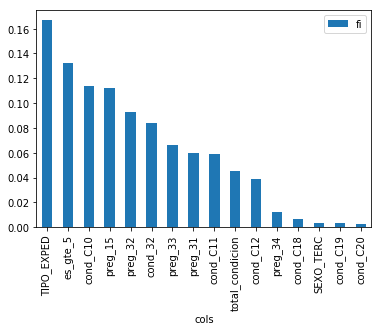

In [48]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [ ]:
# best columns used
rf_fi["cols"].values

# final model

In [ ]:
# reset_rf_samples()

## full features final model

In [41]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train, y_full_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 9},
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=55,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [42]:
y_val_pred = rf_full.predict(X_val)
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, rf_full.predict_proba(X_val)[:, -1])
print("%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI))

0.449, 0.973


In [43]:
confusion_matrix(y_val, y_val_pred)

array([[71143,   360],
       [  116,   194]])

## red features final model

In [40]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train[to_keep], y_full_train)

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 18},
           criterion='gini', max_depth=15, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [22]:
rf_full = ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 18},
           criterion='gini', max_depth=15, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
to_keep = ['es_gte_5', 'TIPO_EXPED', 'cond_C10', 'cond_C11', 'preg_33', 'preg_32', 'preg_31', 'cond_C12', 'cond_32', 'total_condicion', 'preg_15', 'cond_C19', 'preg_34', 'cond_C18', 'cond_C20', 'SEXO_TERC',]
rf_full.fit(X_full_train[to_keep], y_full_train)

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 18},
                     criterion='gini', max_depth=15, max_features='auto',
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=55,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=0, verbose=0, warm_start=False)

In [23]:
y_val_pred_prob = rf_full.predict_proba(X_val[to_keep])[:, -1]
y_val_pred = y_val_pred_prob > 0.5
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
print("%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI))

0.438, 0.972


In [24]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[71103,   400],
       [  111,   199]])

In [42]:
# 0.438, 0.972
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[71103,   400],
       [  111,   199]])

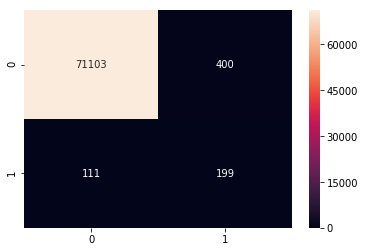

In [26]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador (sum cond >=5) comparison

In [53]:
# comparing against > 5 logic
y_tronador = X_val["total_condicion"] >= 5
print(f"({f1_score(y_val, y_tronador)},{roc_auc_score(y_val, y_tronador)})")

(0.3472949389179756,0.8165133833771018)


In [54]:
conf_mat = confusion_matrix(y_val, y_tronador)
conf_mat

array([[70866,   637],
       [  111,   199]])

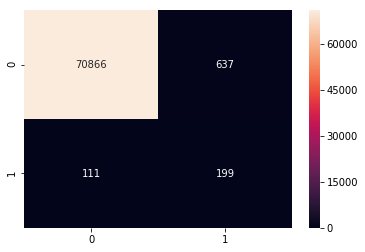

In [73]:
sns.heatmap(conf_mat, annot=True, fmt="d")

# Saving final model & columns used into hard drive

In [27]:
# path_to_save = "../../src/models/1.1 - df_train 01-18to12-18/"
# model_file = os.path.join(path_to_save, f"{model_id} (Model) - Model Optimization recall - class_weight balanced - time sorted.pickle")
model_file =  f"{model_id} (Model) - Model Optimization recall - class_weight balanced - time sorted.pickle"

with open(model_file, "wb") as f:
    pickle.dump(rf_full, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# save file for humans
# model_file = "../../models/1.0 - df_train with nan 01-17to12-18/1.0 - Model for humans - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle"

# with open(model_file, "wb") as f:
#    pickle.dump(rf_full, f, 0) # 0 is human readable format

In [28]:
# merging list input & target
full_cols = list(to_keep) # + ["EXISTE_FRAUDE"]
print(full_cols)

['es_gte_5', 'TIPO_EXPED', 'cond_C10', 'cond_C11', 'preg_33', 'preg_32', 'preg_31', 'cond_C12', 'cond_32', 'total_condicion', 'preg_15', 'cond_C19', 'preg_34', 'cond_C18', 'cond_C20', 'SEXO_TERC']


In [29]:
# path_to_save = "../../src/features/1.1 - df_train 01-18to12-18/"
# columns_file = os.path.join(path_to_save, f"{model_id} (COLUMNS) - Model Optimization - class_weight balanced - time sorted.pickle")
columns_file = f"{model_id} (COLUMNS) - Model Optimization - class_weight balanced - time sorted.pickle"

with open(columns_file, "wb") as file:
    pickle.dump(full_cols, file, pickle.HIGHEST_PROTOCOL)

In [46]:
df_example = X_val.loc[:, to_keep]
df_example["EXISTE_FRAUDE"] = y_val

In [47]:
df_example["es_gte_5"] = df_example["es_gte_5"].replace({True:1, False:0})

In [48]:
df_example["EXISTE_FRAUDE"].value_counts()

False    71503
True       310
Name: EXISTE_FRAUDE, dtype: int64

In [49]:
df_example_sub = (df_example[df_example["EXISTE_FRAUDE"] == 1][:15]).append(df_example[df_example["EXISTE_FRAUDE"] == 0][:15])
df_example_sub["EXISTE_FRAUDE"].value_counts()

True     15
False    15
Name: EXISTE_FRAUDE, dtype: int64

In [50]:
# saving for example a few rows to implement the model
path_to_save = "../../src/data/1.1 - df_train 01-18to12-18/"
sample_file = os.path.join(path_to_save, f"{model_id} (sample)  - dataset example to predict model.csv")
df_example_sub.to_csv(sample_file)

In [51]:
df_example.head()

,es_gte_5,TIPO_EXPED,cond_C10,cond_C11,preg_33,preg_32,preg_31,cond_C12,cond_32,total_condicion,preg_15,cond_C19,preg_34,cond_C18,cond_C20,SEXO_TERC,EXISTE_FRAUDE
0,0,4,-1.0,-1.0,-1,-1,-1,-1.0,-1.0,1.0,-1,-1.0,-1,-1.0,-1.0,-1,False
1,0,4,-1.0,-1.0,-1,-1,-1,-1.0,-1.0,1.0,-1,-1.0,-1,-1.0,-1.0,-1,False
2,0,2,-1.0,-1.0,-1,-1,-1,-1.0,-1.0,1.0,-1,-1.0,-1,-1.0,-1.0,1,False
3,0,3,-1.0,-1.0,-1,-1,-1,-1.0,-1.0,0.0,-1,-1.0,-1,-1.0,-1.0,-1,False
4,0,2,-1.0,-1.0,-1,-1,-1,-1.0,-1.0,0.0,-1,-1.0,-1,-1.0,-1.0,1,False


# Val prediction

In [103]:
df_val = pd.read_feather(os.path.join(path, "1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather"))

In [94]:
# Loding the model

def load_model(model_id):
    """Load the dump model."""
    folder = "models"
    path_to_load = f"../../src/{folder}/1.1 - df_train 01-18to12-18"
    model_file = os.path.join(path_to_load, f"{model_id} (Model) - Model Optimization recall - class_weight balanced - time sorted.pickle")

    with open(model_file, "rb") as file:
        m = pickle.load(file)
    return m


def load_columns(model_id):
    """Load the array of columns use in the dump model."""
    folder = "features"
    path_to_load = f"../../src/{folder}/1.1 - df_train 01-18to12-18"
    columns_file = os.path.join(path_to_load, f"{model_id} (COLUMNS) - Model Optimization - class_weight balanced - time sorted.pickle")

    with open(columns_file, "rb") as file:
        columns = pickle.load(file)
    return columns

In [95]:
m = load_model(model_id)
columns = load_columns(model_id)

In [96]:
X_val = df_val.loc[:, columns].drop(columns="EXISTE_FRAUDE")
y_val = df_val["EXISTE_FRAUDE"]

In [97]:
y_val_pred_prob = m.predict_proba(X_val)[:, -1]

In [98]:
print("%.3f, %.3f" % (f1_score(y_val, y_val_pred_prob > 0.5), roc_auc_score(y_val, y_val_pred_prob)))

0.438, 0.972


In [119]:
conf_mat = confusion_matrix(y_val, y_val_pred_prob > 0.5)
conf_mat

array([[71103,   400],
       [  111,   199]])

In [100]:
df_val.head()

,NUM_SECU_EXPED,cond_04,cond_05,cond_06,cond_09,cond_11,cond_12,cond_32,cond_37,cond_C1,cond_C10,cond_C11,cond_C12,cond_C13,cond_C14,cond_C15,cond_C16,cond_C17,cond_C18,cond_C19,cond_C2,cond_C20,cond_C21,cond_C3,cond_C4,cond_C5,cond_C6,cond_C7,cond_C8,cond_C9,total_condicion,es_gte_5,EXISTE_FRAUDE,EXISTE_INVEST,preg_1,preg_2,preg_3,preg_4,preg_5,preg_6,preg_7,preg_8,preg_9,preg_10,preg_11,preg_12,preg_15,preg_16,preg_18,preg_19,preg_22,preg_24,preg_27,preg_28,preg_30,preg_31,preg_32,preg_33,preg_34,preg_36,preg_37,CATASTROFICO,CERRADURA_BAUL,CERRADURA_DERECHA,CERRADURA_IZQUIERDA,CODIGO_BAJA,CODIGO_CARATULA,CODIGO_REAPERTURA,CODIGO_VEHICULO,COD_CAUSA_SINI,COD_POST_OCURRENCIA,COD_POST_POLIZA,COD_POST_TERC,COD_RAMO_sini,COD_RIES_sini,CONDICION_ROBO_EXP50,DANOS_MATERIALES,DESCRIPCION_TIPO,ESTADO_CIVIL,ESTADO_CIVIL_TERC,ESTAD_VEH_ASEG,FALTANTE,FECHA_SINI,MCA_COASEG,MCA_JUICIO,MCA_VIP,METRO,NUM_SECU_POL,OCUPACION_ASEG,SEXO,SEXO_TERC,TELEFONO_TERC,TIPO,TIPO_EXPED,TIPO_LESION,TIPO_LESION_MAXIMA,TIPO_SINIESTRO,USO,dias_entre_denu_y_sini,dist_fformal_fsini,dist_fformal_fdenu,existe_FECHA_FORMAL,CANT_RENOVACION,CAPITAL_ACCESORIOS,CAPITAL_ASEGURADO_COTIZACION,CAPITAL_VEHICULO,COD_COBRO,COD_COBRO_ANTERIOR,COD_PROD,COD_ZONA_CASCO,COD_ZONA_RC,COD_ZONA_ROBO,CONV_COMISIONARIO,CIF_ID,MCA_AGRAVANTE,MCA_EMPLEADO,MCA_MOVIMIENTO,MCA_POLIZA_VIP,NEGOCIO,PRENDARIO,SEGMENTO,cambio_cobro,ANTIG_pol,COD_EST_CIVIL,TIPO_ACTIVIDAD,CLIENTE,CODIGO_NACION,DATECO_TIPO_ACTIVIDAD,DOMICILIO_CODIGO_POSTAL,HABILITADO,FECHA_SINI_Year,FECHA_SINI_Month,FECHA_SINI_Week,FECHA_SINI_Day,FECHA_SINI_Dayofweek,FECHA_SINI_Dayofyear,FECHA_SINI_Is_month_end,FECHA_SINI_Is_month_start,FECHA_SINI_Is_quarter_end,FECHA_SINI_Is_quarter_start,FECHA_SINI_Is_year_end,FECHA_SINI_Is_year_start,FECHA_SINI_Hour,FECHA_SINI_Minute,FECHA_SINI_Second,FECHA_SINI_Elapsed,cant_pol,cant_sini_1y
0,1916897659999,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,False,False,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1.0,-1.0,-1.0,5542.0,71.0,1702.0,1702.0,-1.0,1.0,1.0,-1.0,0,3,6,-1,3.0,0,2019-02-01,0,-1,0,1,1.915279e+12,44.0,1,-1,-1,3.0,4,-1,-1,2,1.0,0.0,-1.0,-1.0,0,1.0,8,372,646,5,-1,5660.0,1.0,1.0,1.0,107,-1.0,0,0,0,0,-1,0,6,0,0.0,-1,-1,-1,-1,-1,-1.0,-1,2019.0,2.0,5.0,1.0,4.0,32.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1548979200,0.0,0.0
1,1916897679999,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,False,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1.0,-1.0,-1.0,5185.0,71.0,7600.0,7600.0,-1.0,1.0,1.0,-1.0,0,3,6,-1,3.0,1,2019-02-01,0,-1,1,0,1.875676e+12,25.0,1,-1,-1,3.0,4,-1,-1,2,1.0,0.0,-1.0,-1.0,0,33.0,137,4506,9315,5,5,5490.0,2.0,9.0,18.0,107,-1.0,0,0,-1,1,21,0,2,0,975.0,-1,-1,-1,-1,-1,-1.0,-1,2019.0,2.0,5.0,1.0,4.0,32.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1548979200,0.0,0.0
2,1916897949999,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,1.0,0.0,1.0,False,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1.0,-1.0,-1.0,14274.0,501.0,1408.0,1053.0,-1.0,8.0,1.0,-1.0,0,3,0,-1,5.0,1,2019-02-01,0,-1,1,1,1.910147e+12,5.0,1,1,-1,3.0,2,-1,-1,7,1.0,0.0,-1.0,-1.0,0,4.0,8,2293,6514,2,2,73339.0,1.0,1.0,1.0,15,-1.0,1,0,-1,1,47,1,-1,0,77.0,-1,-1,-1,-1,-1,-1.0,-1,2019.0,2.0,5.0,1.0,4.0,32.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1548979200,0.0,0.0
3,1916897969999,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,False,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,-1.0,-1.0,-1.0,14274.0,501.0,1408.0,1053.0,-1.0,8.0,1.0,-1.0,0,3,0,-1,5.0,1,2019-

In [106]:
# getting relevant columns
df_control = df_val[["NUM_SECU_EXPED", "EXISTE_INVEST", "EXISTE_FRAUDE"]].copy()
# unified missing values
df_control["EXISTE_INVEST"].replace({-1:0}, inplace=True)
# saving predictions
df_control["y_pred"] = y_val_pred_prob > 0.5
df_control["y_pred_prob"] = y_val_pred_prob
df_control.head()

,NUM_SECU_EXPED,EXISTE_INVEST,EXISTE_FRAUDE,y_pred,y_pred_prob
0,1916897659999,0,False,False,0.060527
1,1916897679999,0,False,False,0.060527
2,1916897949999,0,False,False,0.005239
3,1916897969999,0,False,False,0.005914
4,1916898069999,0,False,False,0.004595


In [105]:
df_control["EXISTE_INVEST"].value_counts(dropna=False)

0    71241
1      572
Name: EXISTE_INVEST, dtype: int64

In [114]:
df_control["y_pred"].value_counts(dropna=False)

False    71214
True       599
Name: y_pred, dtype: int64

In [113]:
pd.crosstab([df_control["EXISTE_INVEST"], df_control["EXISTE_FRAUDE"]], df_control["y_pred"])

y_pred                       False  True 
EXISTE_INVEST EXISTE_FRAUDE              
0             False          70935    305
              True               0      1
1             False            168     95
              True             111    198

In [110]:
df_control.to_csv("control_pred_invest_valset.csv")

# Test prediction

In [4]:
df_test = pd.read_feather(os.path.join(path, "1.1.b - 01-17 to 01-19 - df_test 04-19to04-19.feather"))

In [5]:
# Loding the model

def load_model(model_id):
    """Load the dump model."""
    folder = "models"
    path_to_load = f"../../src/{folder}/1.1 - df_train 01-18to12-18"
    model_file = os.path.join(path_to_load, f"{model_id} (Model) - Model Optimization recall - class_weight balanced - time sorted.pickle")

    with open(model_file, "rb") as file:
        m = pickle.load(file)
    return m


def load_columns(model_id):
    """Load the array of columns use in the dump model."""
    folder = "features"
    path_to_load = f"../../src/{folder}/1.1 - df_train 01-18to12-18"
    columns_file = os.path.join(path_to_load, f"{model_id} (COLUMNS) - Model Optimization - class_weight balanced - time sorted.pickle")

    with open(columns_file, "rb") as file:
        columns = pickle.load(file)
    return columns

In [6]:
m = load_model(model_id)
columns = load_columns(model_id)

FileNotFoundError: [Errno 2] No such file or directory: '../../src/models/1.1 - df_train 01-18to12-18/1.1.b.2.f.6m (Model) - Model Optimization recall - class_weight balanced - time sorted.pickle'

In [123]:
X_test = df_test.loc[:, columns].drop(columns="EXISTE_FRAUDE")
y_test = df_test["EXISTE_FRAUDE"]

In [124]:
X_test.head()

,es_gte_5,TIPO_EXPED,cond_C10,cond_C11,preg_33,preg_32,preg_31,cond_C12,cond_32,total_condicion,preg_15,cond_C19,preg_34,cond_C18,cond_C20,SEXO_TERC
0,False,3,-1.0,-1.0,-1,-1,-1,-1.0,-1.0,0.0,-1,-1.0,-1,-1.0,-1.0,-1
1,False,3,-1.0,-1.0,-1,-1,-1,-1.0,-1.0,0.0,-1,-1.0,-1,-1.0,-1.0,-1
2,False,5,-1.0,-1.0,-1,1,-1,-1.0,-1.0,4.0,-1,-1.0,-1,-1.0,-1.0,-1
3,False,2,-1.0,-1.0,-1,-1,-1,-1.0,-1.0,0.0,-1,-1.0,-1,-1.0,-1.0,1
4,False,3,-1.0,-1.0,-1,-1,-1,-1.0,-1.0,0.0,-1,-1.0,-1,-1.0,-1.0,-1


# Model in test

In [125]:
y_test_pred_prob = m.predict_proba(X_test)[:, -1]
print("%.3f, %.3f" % (f1_score(y_test, y_test_pred_prob > 0.5), roc_auc_score(y_test, y_test_pred_prob)))

0.414, 0.987


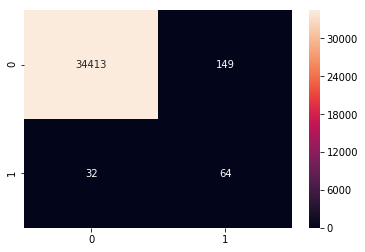

In [126]:
conf_mat = confusion_matrix(y_test, y_test_pred_prob > 0.5)
sns.heatmap(conf_mat, annot=True, fmt="d")

# Tronador in test

In [127]:
y_tronador = X_test["es_gte_5"]
print("%.3f, %.3f" % (f1_score(y_test, y_tronador), roc_auc_score(y_test, y_tronador)))

0.330, 0.851


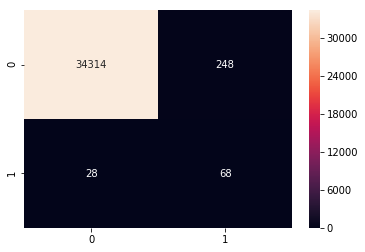

In [128]:
conf_mat = confusion_matrix(y_test, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [33]:
158 / 248

0.6370967741935484

In [37]:
X_test.head()

,cond_C10,es_gte_5,TIPO_EXPED,preg_15,cond_C12,preg_32,cond_32,preg_33,preg_31,cond_C11,preg_34,COD_CAUSA_SINI,cond_C2,cond_C3,METRO,SEXO_TERC,OCUPACION_ASEG,FALTANTE,cond_C5,CONDICION_ROBO_EXP50
0,-1.0,False,3,-1,-1.0,-1,-1.0,-1,-1,-1.0,-1,226.0,-1.0,-1.0,1,-1,44.0,1,-1.0,-1.0
1,-1.0,False,3,-1,-1.0,-1,-1.0,-1,-1,-1.0,-1,226.0,-1.0,-1.0,1,-1,5.0,1,-1.0,-1.0
2,-1.0,False,5,-1,-1.0,1,-1.0,-1,-1,-1.0,-1,202.0,3.0,0.0,1,-1,44.0,1,0.0,1.0
3,-1.0,False,2,-1,-1.0,-1,-1.0,-1,-1,-1.0,-1,501.0,-1.0,-1.0,0,1,44.0,1,-1.0,-1.0
4,-1.0,False,3,-1,-1.0,-1,-1.0,-1,-1,-1.0,-1,501.0,-1.0,-1.0,0,-1,44.0,1,-1.0,-1.0


In [38]:
X_test.shape

(34658, 20)